In [86]:
import networkx as nx 
import random
import matplotlib.pyplot as plt
import numpy as np 
import math 
import copy 
import graphviz
from scipy.optimize import fsolve
from typing import List
import sympy as sp
from sympy import Symbol
from collections import deque

In [235]:
class Arrival():
    
    def __init__(self,n):
        self.n = n # number of nodes
        self.vertices = [v for v in range(n)] # zero is origin and n is the destination 
        self.s_0 = np.array([random.choice([i for i in range(n) if i != v]) for v in self.vertices])  # even successors
        self.s_1 = np.array([random.choice([i for i in range(n) if i != v]) for v in self.vertices])  # odd successors
      
        # Some edges can have both successor as themselves, acting as sinks. should this be allowed??
        self.s_curr = np.copy(self.s_0) # current switches for each node
        self.s_next = np.copy(self.s_1) # next switch for each node
        self.start_node = 0 # current node 
        self.target_node = self.vertices[-1]
        
        # Construct Graph Structure and Equations for node visit counts
        self.raw_graph = self.get_network_graph()
        self.graph = self.combine_unreachable_nodes()
        self.X,self.equations = self.get_equations()
        
        self.draw_graph(self.graph)
        
    
    def __repr__(self):
        return f"Even Successors: {self.s_0}\nOdd Successors: {self.s_1}\nCurrent Switches: {self.s_curr}\nNext Switches: {self.s_next}\nCurrent Node: {self.v}"
    
    def next_node(self,v):
        assert v < self.n
        next = self.s_curr[v]
        self.s_curr[v] = self.s_next[v]
        self.next[v] = next
        return next
        
    def get_network_graph(self):
        G = nx.DiGraph()
        G.add_nodes_from(self.vertices, d_dash=False)
        
        for v in self.vertices:
            G.add_edge(v,self.s_0[v],label='0')
            G.add_edge(v,self.s_1[v],label='1')
            
        return G
        
    def combine_unreachable_nodes(self):
        print(list(nx.isolates(self.raw_graph)))
        reachable_nodes = nx.descendants(self.raw_graph, self.start_node) | {self.start_node}
        # reachable_nodes = nx.ancestors(self.raw_graph, self.target_node) | {self.target_node}

        new_G = nx.DiGraph()
        mapping = {}
        counter = 0
        for node in self.raw_graph.nodes():
            if node in reachable_nodes:
                mapping[node] = counter
                counter += 1
            else:
                mapping[node] = -1
        # print(mapping)
        new_G.add_node(-1)

        for edge in self.raw_graph.edges():
            source, target = edge
            if source in reachable_nodes and target in reachable_nodes:
                ## add the edge with the same nodes and labels
                new_G.add_edge(mapping[source], mapping[target],label=self.raw_graph[source][target]['label'])
            elif source not in reachable_nodes:
                ## 
                new_G.add_edge(mapping[source], -1,label=self.raw_graph[source][target]['label'])

        new_G.add_edge(-1, -1,label = '1')
        new_G.add_edge(-1, -1,label = '0')
        
        ## Changing the vertices and s_0 and s_1 adjacency lists
        self.vertices = list(new_G.nodes)
        self.n = len(self.vertices)
        print(n)
        return new_G

    def get_equations(self):
        symbol_nodes = list(self.graph.nodes)
        symbol_nodes.sort()
        
        X = sp.symbols(' '.join([f"X{i}" for i in symbol_nodes]),positive=True)
        
        equations = []
        for v in symbol_nodes:
            odd_parents = []
            even_parents = []
            for e in self.graph.in_edges(v):
                if self.graph.get_edge_data(*e)['label'] == 1:
                    odd_parents.append(e[0])
                else:
                    even_parents.append(e[0])
            
            parent_sum = sp.sympify(0)
            for p in odd_parents:
                parent_sum += sp.floor(X[p]/2)
            for p in even_parents:
                parent_sum += sp.ceiling(X[p]/2)
            # parent_sum = sum([math.floor(X[p]/2) for p in odd_parents]) + sum([math.ceil(X[p]/2) for p in even_parents])
            # eq = X[v] - (parent_sum + 1) if v == 0 else X[v] - parent_sum # origin is visited one more time
            total_sum = (parent_sum + 1) if v == 0 else parent_sum # origin is visited one more time
            eq = sp.Min(total_sum,self.n*(2**self.n))
            equations.append(eq)
            
        return X,equations
    
    def evaluate(self,x):
        assert len(x) == self.n
        # make sympy assignments of given values 
        assignment = {self.X[i]: value_i for i, value_i in enumerate(x)}
        
        results = []
        for eq in self.equations:
            # substitute assignments in equations
            result = eq.subs(assignment)
            results.append(result)
        
        return np.array(results)
    
    def draw_graph(self,G):
        pos = nx.spring_layout(G)
        edge_labels = nx.get_edge_attributes(G, 'label')
        # node_labels = nx.get_node_attributes(self.graph, 'd_dash')
        nx.draw(G,pos, with_labels=True, node_size=200)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
        # nx.draw_networkx_labels(self.raw_graph, pos, labels=node_labels)
        
        plt.show()
    
    def save_graph(self,filename):
        ## TODO save graph from self.graph in pdf as well as .npy file
        g = graphviz.Digraph('G', filename=filename)
        # g.edges(self.vertices)
        for v in range(self.n):
            g.edge(str(v),str(self.s_0[v]),label='0')
            g.edge(str(v),str(self.s_1[v]),label='1')
            
        g.view()
            
    
##### driver code 
# a = Arrival(5)

# # print(a.s_0)
# a.plot_graph('arrival.gv')

In [232]:
def is_converged(x_new, x_old, tol=0):
    """
    Component-wise check.
    """
    return np.max(np.abs(x_new - x_old)) <= tol

In [233]:
def calculate_fixed_point(f, x0, max_iterations=100000, tol=0):
    """
    Calculate the fixed point of the monotone function f using iteration.
    """
    x_old = x0.copy()
    
    for i in range(max_iterations):
        x_new = f(x_old)
        
        if is_converged(x_new, x_old, tol):
            return x_new
        
        x_old = x_new
        print(f"iteration {i} : {x_new}")
    
    raise Exception("Fixed point calculation did not converge within the maximum iterations.")


[]
100


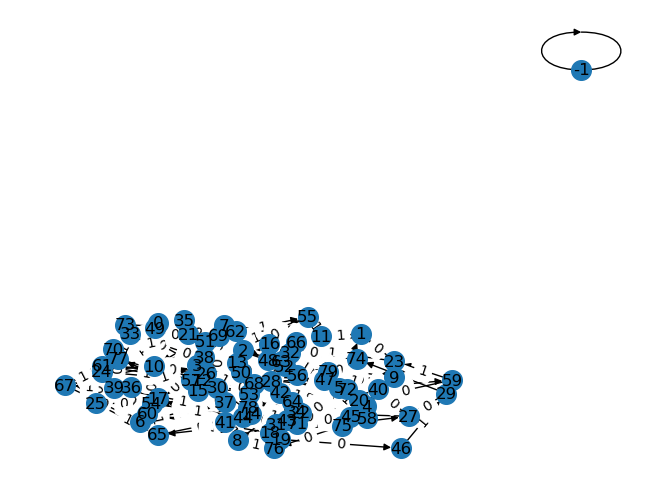

iteration 0 : [0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
iteration 1 : [0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
iteration 2 : [0 2 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0
 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0
 0 0 0 0 1 0 0]
iteration 3 : [0 1 1 0 1 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0
 0 4 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 2 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0
 0 0 1 0 0 0 0]
iteration 4 : [0 1 0 2 2 1 0 0 0 1 0 1 2 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0 2 0 0 0 0 0 0 0 0
 0 2 2 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 2 0 0 0 1 4 1 1 1 1 1 1 2 1 1 0 1 1
 0 1 0 0 0 4 0]
iteration 5 : [0 2 1 2 2 3 1 1 1 0 1 1 3 0 0 1 0 0 0 0 2 0 1 0 1 1 1 0 0 1 0 1 0 0 1 1 1
 1 2 2 1 0 

KeyboardInterrupt: 

In [245]:

# Define the initial guess for the fixed point calculation
n = 100
game = Arrival(n)
# print(len(game.equations))
x0 = np.zeros(game.n)
x0[0] = 1

# Calculate the fixed point
fixed_point = calculate_fixed_point(game.evaluate, x0)

print("Fixed point:", fixed_point)

In [244]:
# game.graph.nodes
game.graph.edges

OutEdgeView([(-1, -1), (0, 23), (0, 16), (23, 3), (23, 10), (16, 23), (16, 13), (1, 0), (1, 24), (24, 23), (24, 12), (2, 17), (2, 10), (17, 2), (17, 16), (10, 15), (10, 19), (3, 4), (3, 16), (4, 22), (4, 23), (22, 11), (22, 15), (5, 14), (5, 21), (14, 20), (14, 24), (21, 7), (6, 12), (6, 9), (12, 21), (12, 10), (9, 0), (7, 1), (7, 8), (8, 19), (8, 17), (19, 14), (19, 7), (15, 11), (15, 18), (11, 18), (11, 6), (18, 14), (18, 3), (13, 0), (13, 20), (20, 5), (20, 13)])